## Introduction
At present there are approximately 7.7 billion people in the world with at least 3.5 billion of us online, implying that social media platforms are used by approximately one-in-three people in the world. This sudden growth and adoption has transformed the way we find partners, access news and information, or even how we organize political change and in so many other different ways. Leveraging the power of social media is now more important than ever before. This project aims to optimize social media activity for our users by providing them suggestions based on the analysis of data that we get from the Twitter API. Specifically,our project will have four key features that will provide suggestions on the following: 
    1. What the best time to post on social media would be 
    2. What are some keywords to include in a tweet based on post category and trending tweets 
    3. What are some hashtags to include in a tweet based on post category and trending tweets 
    4. What is the sentiment of the tweet the user has drafted
For this project, we will be focusing specifically on Twitter. We have developed these four features because these are the four main components of a tweet that a user should think about before posting it. We want to ensure that a user is posting their tweet when the most people are going to see it. Additionally, we want to provide the user with suggestions of content, including the words itself and the hashtags, that has shown to be popular. Finally, we also want to ensure that the content that the user inputted is reflecting the same sentiment that they are intending to express.

## Table of Contents
- [Architecture Diagram](#Architecture-Diagram)
- [Installing the Libraries](#Installing-the-Libraries)
- [User Input](#User-Input)
- [Gathering the Data](#Gathering-the-Data)
    - [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
    - [Webscraping](#Webscraping)
    - [Twitter API](#Twitter-API)
- [Finding the Best Time to Post](#Finding-the-Best-Time-to-Post)
- [Predicting Popular Keywords](#Predicting-Popular-Keywords)
- [Predicting Hashtags](#Predicting-Hashtags)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Future Research and Study](#Future-Research-and-Study)

## Architecture Diagram

Below we have illustrated the pipeline that the data will follow. With our project, we will have the user input their username, the tweet that they intend on posting, and the category or categories of the tweet that the content of their tweet falls under. With this data, we can use the Twitter API to begin building a database of all the tweets that were posted globally that fall under the category that the user inputed. We also use webscraping to build a database of all of the tweets and posts on the users timeline. With this data, we can do a time series analysis to analyze the best time for social media engagment globally for the inputted category, as well as specifically for the user. Additionally, after we have cleaned and processed the data, we can use TFIDF to analyze the most popular keywords and hashtags for all tweets globally within the given category, as well as for all of the tweets of the user. Finally, we can use a sentiment analysis model to analyze the sentiment behind the tweet that the user intends on posting. 

<img src = "Capture.png" align = "center">

## Installing the Libraries

In order to gather the data, we will mainly be using Tweepy and the Twitter API, as well as, Selenium for webscraping. For each component of our project, we will be using different module for each component. For the time component, we will mainly be using Pandas for the time series analysis. For the keywords and hashtags, we will mainly be using the sklearn module. Finally, for the sentiment analysis, we will be using the Textblob and NLTK. 

In [135]:
import requests
import urllib
import tweepy
import json
import csv
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import re
import io
import time
from datetime import datetime
from bs4 import BeautifulSoup
from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

## User Input

We will have the user input their username or Twitter handle to us for webscraping. We will also have the user input the tweet that they intend on posting for sentiment analysis. Finally, we will have the user input the category of their tweet in order to gather data on tweets that are more relevant to the tweet that the user wants to post.

In [171]:
user_name = input("What is your username? ")

What is your username? elonmusk


In [162]:
orig_tweet = input("What is your tweet? ")
#"Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design"

What is your tweet? Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design


In [172]:
#Possible Categories are: Sports", "Politics", "Entertainment", "Education", "Technology", "Business"
orig_categories = input("What is the category of your tweet? These are the possible categories: Sports, Politics, Entertainment, Education, Technology, Business. Please input the categories comma separated. ")
orig_categories = orig_categories.split(",")

What is the category of your tweet? These are the possible categories: Sports, Politics, Entertainment, Education, Technology, Business. Please input the categories comma separated. Business, Technology


##  Gathering the Data

To begin with, we need to gather our data from Twitter. We will be using the Twitter API to get all of the tweets that were posted globally in the specfic inputted category. Then, we will be using webscraping to scrape the all of the posts from the user's timeline. However, in order to use the data that we have gathered, we need to clean and preprocess the data so that we can complete our analyses.

### Data Cleaning and Preprocessing

Below, we have listed out all of the functions that we will need to use in our project in order to process and analyze our data. In order to analyze the content of the user's intended tweet, the content of global tweets, and the content of the tweets on the user's timeline, we will need to replace all characters in each tweet that are not UTF-8 with a description of the emoji, remove all all of the extremely common words, or the stopwords, and break down the tweet into tokens of it's keywords and it's hashtags.

In [137]:
### replace emojis with descriptions of the emojis 
def de_emoji(tweet):
    new_tweet = ""
    emojis = []
    for character in tweet:
        try:
            character.encode("ascii")
            new_tweet += character
        except UnicodeEncodeError:
            replaced = unidecode(str(character))
            if replaced != '' and replaced !="[?]":
                new_tweet += replaced
            else:
                try:
                    emojis.append(unicodedata.name(character))
                except ValueError:
                     new_tweet += "[x]"
    return new_tweet, ",".join(emojis)
orig_tweet, orig_emojis = de_emoji(orig_tweet)
print("Tweet without emojis: "+orig_tweet+"\n")
print("Description of Emojis Used: "+orig_emojis)

Tweet without emojis: Huge thanks to everyone who contributed ideas to Cybertruck. It's better because of you!  #Tesla #Tech2020 #Design

Description of Emojis Used: BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16


In [138]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
def preprocess(tweet):
    
    ## lowercase
    lower_case = tweet.lower()
    lower_case= re.sub("'s", "", lower_case)
    
    ## removing apostrophes
    lower_case = lower_case.translate(str.maketrans('', '', "'"))
    lower_case = lower_case.translate(str.maketrans('', '', '"'))
    
    ## removing punctuation, only considering alphanumeric characters
    tweet_list = re.split('[^a-zA-Z0-9]', lower_case)
    
    str_list = [x for x in tweet_list if x != '']
    
    ## lemmatizing each word
    str_list = [lemmatizer.lemmatize(x) for x in str_list]
    
    ## removing stopwords
    str_list = [x for x in str_list if x not in stopwords.words('english')]
    
    hashtags, mentions = [], []
    ## Creating a seperate lists for tweet texts, hashtags(#twitter), mentions(@elonmusk, @carnegiemellon)
    for word in lower_case.split():
        word = word.strip()
        if len(word)>0 and word[0]=="@":
            mentions.append(word)
        if len(word)>0 and word[0]=="#":
            hashtags.append(word)
    return str_list, hashtags, mentions
clean_tweet, hashtags, mentions = preprocess(orig_tweet)
print(clean_tweet, hashtags, mentions)

['huge', 'thanks', 'everyone', 'contributed', 'idea', 'cybertruck', 'better', 'tesla', 'tech2020', 'design'] ['#tesla', '#tech2020', '#design'] []


#### Cleaning the Data

Before we complete any of our analyses, we will be using all of the functions in our `clean_tweets` function to break down the content of our tweets into it's different components that we can analyze.

In [142]:
## Clean all tweets 
def clean_tweets(df):
    clean_tweet, hashtags, mentions, emojis = [], [], [], []
    for tweet in df['text']:
        tweet, emoji = de_emoji(tweet)
        tweet, hashtag, mention = preprocess(tweet)
        clean_tweet.append(tweet)
        hashtags.append(hashtag)
        mentions.append(mention)
        emojis.append(emoji)
    df['text'] = clean_tweet
    df['hashtags'] = hashtags
    df['mentions'] = mentions
    return df

#### Reformatting the Data

We will be using this function to reformat the time data that we are gathering from the webscraping to a DateTimeIndex format for our time series analysis.

In [75]:
def convert24(str1): 
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[-2:] == "AM" and str1[:2] == "12": 
        return "00" + str1[2:-2]     
    # remove the AM     
    elif str1[-2:] == "AM": 
        return str1[:-2] 
    elif str1[-2:] == "PM" and str1[:2] == "12": 
        return str1[:-2] 
    else: 
        # add 12 to hours and remove PM 
        return str(int(str1[:2]) + 12) + str1[2:6] 
convert24('03:01 PM')

def convertMonth(month):
    m = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr':4,
         'May':5,
         'Jun':6,
         'Jul':7,
         'Aug':8,
         'Sep':9,
         'Oct':10,
         'Nov':11,
         'Dec':12
        }
    return m[month]  

In [92]:
def format_date(user_timeline_df):
    user_timeline_df['created_at'] = user_timeline_df['created_at'].astype(str)
    for index,row in user_timeline_df.iterrows():
        #print(row['created_at'])
        dash_index = row['created_at'].find("-")
        if ":" in row['created_at'][:2]:
            time = '0' + row['created_at'][:dash_index-1]
        else:
            time = row['created_at'][:dash_index-1]
        time = convert24(time)[:-1] + ':00'
        #print(row['created_at'][index+2:])
        year = row['created_at'][dash_index+2:][-4:] + "-"
        #print(row['created_at'][dash_index+2:][-8:-5])
        month = str(convertMonth(row['created_at'][dash_index+2:][-8:-5])) + '-'
        if " " in row['created_at'][dash_index+2:][:2]:
            day = "0" + row['created_at'][dash_index+2:][0]
        else:
            day = row['created_at'][dash_index+2:][:2]
        date = year + month + day
        user_timeline_df[index:]['created_at'] = date + " " + time
    return user_timeline_df
    
#user_timeline_df = format_date(user_timeline_df)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             created_at                                               text  \
0   2019-12-10 15:01:00  #Saints DE Marcus Davenport suffered a signifi...   
1   2019-12-10 15:00:00  All the best touchdowns from an AMAZING Week 1...   
2   2019-12-10 14:26:00  RT to cast a #ProBowlVote for our Bucks\n@Cant...   
3   2019-12-10 14:30:00  These five rookies balled out in Week 14!  (vi...   
4   2019-12-10 14:00:00  Source: #Redskins RB Derrius Guice is going on...   
5   2019-12-10 14:00:00  The @Vikings defense was DOMINANT in Week 14. ...   
6   2019-12-09 18:00:00  The Walmart in Fort Pierce, Fla., revealed Bea...   
7   2019-12-10 12:47:00   Time to support your Tigers in the @NFL \n RT...   
8   2019-12-10 13:05:00  Eagles WR Alshon Jeffery (foot) to miss rest o...   
9   2019-12-10 13:00:00  2019 Passing Yards Leaders through Week 14! \n...   
10  2019-12-10 12:45:00  Lamar Jackson (quad) on the field at #Ravens w...   
11  2019-12-10 12:39:00  The 15 HIGHEST-GRADED players from Week

### Webscraping

In [139]:
## Scraping the user's timelines
def scraped_timeline(content, page, seen_tweets):
    soup = BeautifulSoup(page, "html.parser")
    timeline = soup.select('#timeline li.stream-item')
    for i, tweet in enumerate(timeline):
        count = tweet.select('span.ProfileTweet-actionCount')
        favs = 0.0
        retweets = 0.0
        for j in range(1, 3):  
            elem = count[j]
            val = elem.get_text().strip()
            num = ""
            i = 0
            while (i<len(val) and not(val[i]== " " or val[i]=="")):
                num+=val[i]
                i+=1
            if num!="":
                num = num.replace(',' , '')
                if num.isdigit():
                    if j==1:
                        retweets = int(num)
                    elif j==2:
                        favs = int(num)
        tweet_text = tweet.select('p.tweet-text')[0].get_text()
        tweet_time = tweet.select('a.tweet-timestamp')
        for elem in tweet_time:
            time = (elem.get('title'))   
        if tweet_text not in seen_tweets:
            seen_tweets.add(tweet.text)
            text, emojis = deEmojify(tweet_text)
            content["created_at"].append(time)
            content["text"].append(text)
            content["emojis"].append(emojis)
            content["favorite_count"].append(favs)
            content["retweet_count"].append(retweets)
            
    return    

In [140]:
def create_timeline_df(user_name, no_of_pagedowns=1):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    browser = driver
    url = "https://twitter.com/" + user_name
    browser.get(url)
    time.sleep(1)
    elem = browser.find_element_by_tag_name("body")
    while no_of_pagedowns>=0:
        elem.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
        no_of_pagedowns-=1

    content = {"created_at":[], "text":[], "emojis":[], "favorite_count":[], "retweet_count":[]}
    seen_tweets = set()
    html_source = scraped_timeline(content, browser.page_source, seen_tweets)
    user_timeline_df = pd.DataFrame.from_dict(content)
    return user_timeline_df

In [141]:
user_timeline_df = create_timeline_df(user_name)
clean_tweet, hashtags, mentions, emojis = [], [], [], []
for tweet in user_timeline_df['text']:
    tweet, emoji = de_emoji(tweet)
    tweet, hashtag, mention = preprocess(tweet)
    clean_tweet.append(tweet)
    hashtags.append(hashtag)
    mentions.append(mention)
    emojis.append(emoji)
user_timeline_df['text'] = clean_tweet
user_timeline_df['hashtags'] = hashtags
user_timeline_df['mentions'] = mentions
user_timeline_df['emojis'] = emojis
user_timeline_df = format_date(user_timeline_df)
user_timeline_df

Trying to download new driver from http://chromedriver.storage.googleapis.com/78.0.3904.105/chromedriver_win32.zip
Unpack archive C:\Users\User\.wdm\drivers\chromedriver\78.0.3904.105\win32\chromedriver.zip


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\User\\.wdm\\drivers\\chromedriver\\78.0.3904.105\\win32\\chromedriver.exe'

### Twitter API

In [143]:
#from retrying import retry

#@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def get_tweets():
    consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
    consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
    access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
    access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
    
    try:
        print("hello")
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)

        csvFile = open('final-project-tweets.csv', 'a')

        #Use csv writer
        csvWriter = csv.writer(csvFile)
        csvWriter.writerow(["category", "screen_name", "created_at", "text", "emojis", "favorite_count", "retweet_count", "follower_count"])
        categories = ["Sports", "Politics", "Entertainment", "Education", "Technology", "Business"]
        dates = ["11-27", "11-28", "11-29", "11-30", "11-31", "12-1", "12-2", "12-3", "12-4"]
        for category in categories:
            for date in range(len(dates)-1):
                for tweet in tweepy.Cursor(api.search,q = category,since = "2019-"+dates[date],until = "2019-"+dates[date+1],lang = "en", result_type = 'popular').items():
                    text, emojis = deEmojify(tweet.text)
                    csvWriter.writerow([category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count])
                    #print(category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count) #, tweet.get_tweet_sentiment(tweet.test))
                    time.sleep(.200)
                    #print (tweet.user.screen_name, tweet.created_at, tweet.text)
        csvFile.close()
    except tweepy.error.TweepError:
        raise
        
get_tweets()

hello


## Time 

### Global

In [144]:
data = pd.read_csv("final-project-tweets.csv") 
data.head()

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count
0,Sports,AlwaysLateESPN,2019-12-02 22:30:12,What are we doing this week to ruin sports for...,SMILING FACE WITH HORNS,68595,15994,30470
1,Sports,DVATW,2019-12-02 20:13:55,"Enthusiastic ""new Swede"" proves his sporting i...",NaN,916,642,129758
2,Sports,FCBarcelona,2019-12-02 22:41:05,[?][?] The sports world hails Leo #Messi #Ball...,NaN,14383,2244,31410733
3,Sports,faizanlakhani,2019-12-02 19:03:51,"Few bad games in Cricket and everyone, from sh...",NaN,2087,342,181730
4,Sports,DanWetzel,2019-12-02 21:05:24,"The repetitive relic that is ""Conference Champ...",NaN,1129,210,291320


In [148]:
data['created_at'] = pd.DatetimeIndex(data['created_at'])
data['created_at'] = data['created_at'].dt.time.astype(str)
data['created_at'] = pd.DatetimeIndex(data['created_at'])
data['popularity'] = (data['favorite_count'] + data['retweet_count'])/data['follower_count']

In [149]:
data

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,popularity
0,Sports,AlwaysLateESPN,2019-12-11 22:30:12,What are we doing this week to ruin sports for...,SMILING FACE WITH HORNS,68595,15994,30470,2.776140
1,Sports,DVATW,2019-12-11 20:13:55,"Enthusiastic ""new Swede"" proves his sporting i...",NaN,916,642,129758,0.012007
2,Sports,FCBarcelona,2019-12-11 22:41:05,[?][?] The sports world hails Leo #Messi #Ball...,NaN,14383,2244,31410733,0.000529
3,Sports,faizanlakhani,2019-12-11 19:03:51,"Few bad games in Cricket and everyone, from sh...",NaN,2087,342,181730,0.013366
4,Sports,DanWetzel,2019-12-11 21:05:24,"The repetitive relic that is ""Conference Champ...",NaN,1129,210,291320,0.004596
5,Sports,roaringriot,2019-12-11 17:46:56,"We are still Panthers fans today, forever and ...",NaN,295,228,18932,0.027625
6,Sports,SkyFootball,2019-12-11 21:38:56,Austin converts from the spot in the 90th minu...,NaN,970,114,352007,0.003079
7,Sports,NFL,2019-12-11 23:54:36,.@stefondiggs playing catch with fans pregame!...,"AMERICAN FOOTBALL,TELEVISION,MOBILE PHONE",705,81,24818782,0.000032
8,Sports,NFL,2019-12-11 23:40:48,"Canada's own @LWillson_82 loves that look, @TD...","FACE WITH TEARS OF JOY,REGIONAL INDICATOR SYMB...",668,85,24818782,0.000030
9,Sports,chiproytx,2019-12-11 21:20:16,"""J.K. Dobbins' mom, Mya, became pregnant when ...",NaN,225,95,22615,0.014150


Timestamp('2019-12-11 18:30:00', freq='30T')

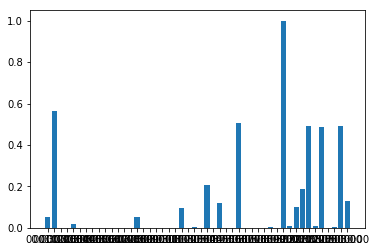

In [150]:
def get_max_time_category(category):
    groups = data.groupby(['category'])
    category = groups.get_group(category)
    time_grpr = category.groupby(pd.Grouper(key='created_at', freq='30min'))
    count_grpr = time_grpr['text'].count()
    sum_grpr = time_grpr['popularity'].sum()
    popularity = sum_grpr/count_grpr
    popularity = (popularity - popularity.min()) / (popularity.max() - popularity.min()) 
    popularity = popularity.fillna(0)
    popularity = popularity.rename('popularity')
    popularity_df = popularity.to_frame()
    popularity_df['tmpstmp'] = popularity.index
    popularity_df['tmpstmp'] = popularity_df['tmpstmp'].dt.time.astype(str)
    plt.bar(popularity_df['tmpstmp'],height = popularity_df['popularity'])
    max_time = popularity_df['popularity'].idxmax()
    return max_time

get_max_time_category('Politics')

### User Specific

In [ ]:
consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
print("hello")
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
user = api.get_user(user_name)
follower_count = user.followers_count

In [151]:
user_timeline_df['created_at'] = user_timeline_df['created_at'].astype(str)
user_timeline_df['created_at'] = pd.DatetimeIndex(user_timeline_df['created_at'])
user_timeline_df['created_at'] = user_timeline_df['created_at'].dt.time.astype(str)
user_timeline_df['created_at'] = pd.DatetimeIndex(user_timeline_df['created_at'])
user_timeline_df['popularity'] = (user_timeline_df['favorite_count'] + user_timeline_df['retweet_count'])/follower_count
user_timeline_df['popularity'] = (user_timeline_df['popularity'] - user_timeline_df['popularity'].min()) / (user_timeline_df['popularity'].max() - user_timeline_df['popularity'].min())
user_timeline_df

hello


,created_at,text,emojis,favorite_count,retweet_count,popularity
0,2019-12-11 15:01:00,#Saints DE Marcus Davenport suffered a signifi...,,329.0,158.0,0.323373
1,2019-12-11 15:00:00,All the best touchdowns from an AMAZING Week 1...,,342.0,61.0,0.267596
2,2019-12-11 14:26:00,RT to cast a #ProBowlVote for our Bucks\n@Cant...,,760.0,746.0,1.000000
3,2019-12-11 14:30:00,These five rookies balled out in Week 14! (vi...,,320.0,39.0,0.238380
4,2019-12-11 14:00:00,Source: #Redskins RB Derrius Guice is going on...,,973.0,199.0,0.778220
5,2019-12-11 14:00:00,The @Vikings defense was DOMINANT in Week 14. ...,,303.0,43.0,0.229748
6,2019-12-11 18:00:00,"The Walmart in Fort Pierce, Fla., revealed Bea...",,0.0,0.0,0.000000
7,2019-12-11 12:47:00,Time to support your Tigers in the @NFL \n RT...,,467.0,350.0,0.542497
8,2019-12-11 13:05:00,Eagles WR Alshon Jeffery (foot) to miss rest o...,,940.0,213.0,0.765604
9,2019-12-11 13:00:00,2019 Passing Yards Leaders through Week 14! \n...,,794.0,133.0,0.615538


In [130]:
def get_max_time_user():
    user_time_grpr = user_timeline_df.groupby(pd.Grouper(key='created_at', freq='10min'))
    user_count_grpr = user_time_grpr['text'].count()
    user_sum_grpr = user_time_grpr['popularity'].sum()
    user_popularity = user_sum_grpr/user_count_grpr
    user_popularity = user_popularity.fillna(0)
    user_popularity = user_popularity.rename('popularity')
    user_popularity_df = user_popularity.to_frame()
    user_popularity_df['tmpstmp'] = user_popularity.index
    user_popularity_df['tmpstmp'] = user_popularity_df['tmpstmp'].dt.time.astype(str)
    plt.bar(user_popularity_df['tmpstmp'],height = user_popularity_df['popularity'])
    user_max_time = user_popularity_df['popularity'].idxmax()
    return user_max_time

user_max_time()

                     popularity             tmpstmp
created_at                                         
2019-12-10 09:30:00    0.841965 2019-12-10 09:30:00
2019-12-10 09:40:00    0.000000 2019-12-10 09:40:00
2019-12-10 09:50:00    0.691235 2019-12-10 09:50:00
2019-12-10 10:00:00    0.656707 2019-12-10 10:00:00
2019-12-10 10:10:00    0.000000 2019-12-10 10:10:00
2019-12-10 10:20:00    0.000000 2019-12-10 10:20:00
2019-12-10 10:30:00    0.000000 2019-12-10 10:30:00
2019-12-10 10:40:00    0.000000 2019-12-10 10:40:00
2019-12-10 10:50:00    0.000000 2019-12-10 10:50:00
2019-12-10 11:00:00    0.142098 2019-12-10 11:00:00
2019-12-10 11:10:00    0.000000 2019-12-10 11:10:00
2019-12-10 11:20:00    0.000000 2019-12-10 11:20:00
2019-12-10 11:30:00    0.000000 2019-12-10 11:30:00
2019-12-10 11:40:00    0.000000 2019-12-10 11:40:00
2019-12-10 11:50:00    0.000000 2019-12-10 11:50:00
2019-12-10 12:00:00    0.092297 2019-12-10 12:00:00
2019-12-10 12:10:00    0.596282 2019-12-10 12:10:00
2019-12-10 1

## Predicting Hashtags

## Sentiment Analysis

In [152]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    print(analysis.sentiment)
    if analysis.sentiment.polarity >= 0:
        return 'positive'
    else:
        return 'negative'
    
fetch_sentiment_using_textblob(orig_tweet)

Sentiment(polarity=0.4083333333333334, subjectivity=0.5333333333333333)


'positive'